In [1]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np,  seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [5]:
import sklearn

In [6]:
df = pd.read_excel("../AmesHousing.xls")

In [7]:
#df imputed will have all continuous columns imputed 
df_imputed = df.copy()

In [8]:
indexed_columns = []

for element in enumerate(list(df)):
    indexed_columns.append(element)

In [9]:
continuous_indices = [4,5,27,35,37,38,39,44,45,46,47,63,67,68,69,70,71,72,76,81]

In [10]:
cont_column_names = [indexed_columns[x][1] for x in continuous_indices]

In [11]:
cont_column_names

['Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'SalePrice']

In [12]:
#perform imputation -- should I do this for visualization purposes
for col in cont_column_names:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())


**1.1 Visualize the univariate distribution of each continuous, and the distribution of the target. Do
you notice anything? Is there something that might require special treatment?**

Distribution of all continuous variables and that of the target (salesprice). The graph for the target is shown last.

/home/andres/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


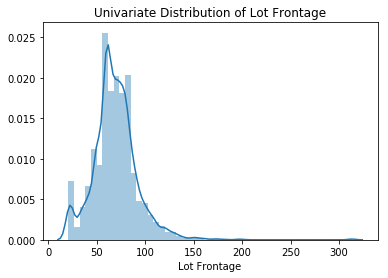

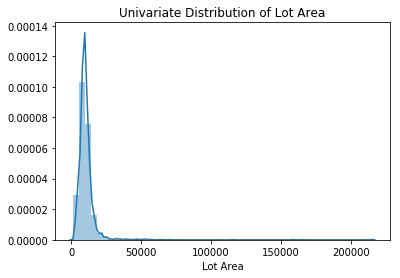

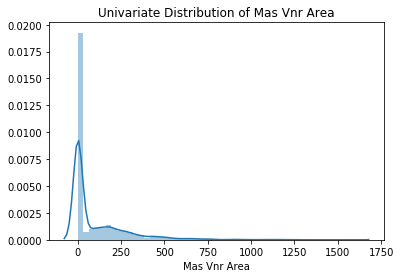

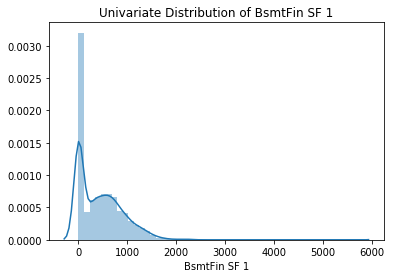

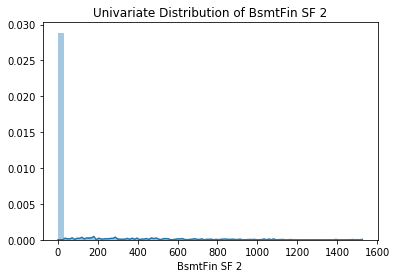

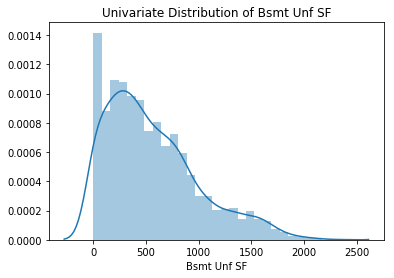

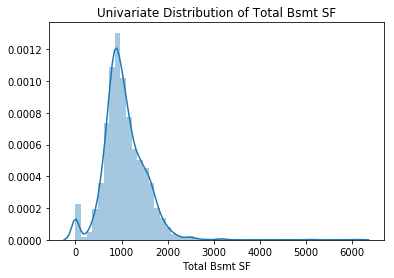

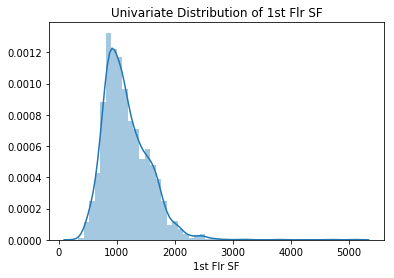

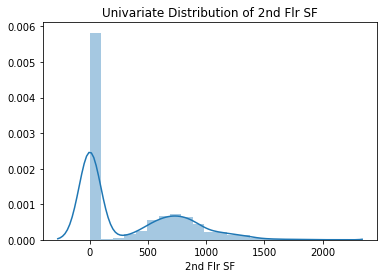

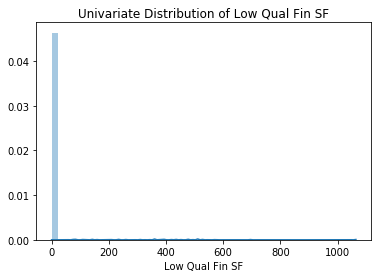

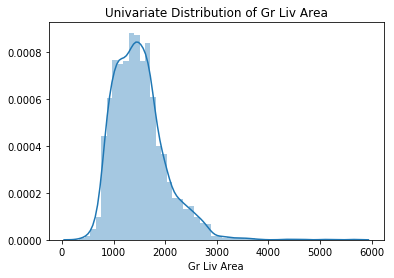

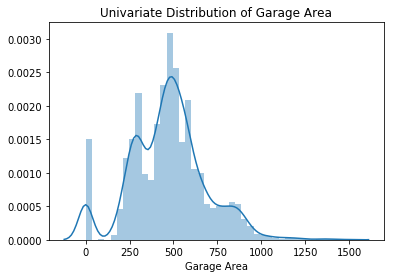

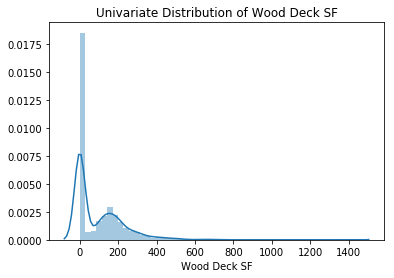

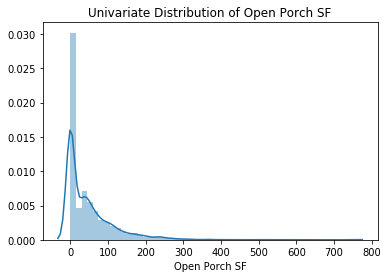

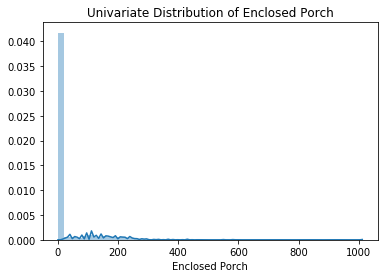

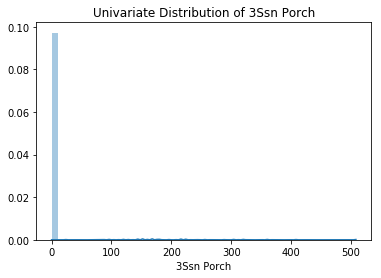

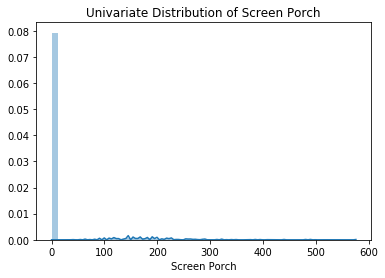

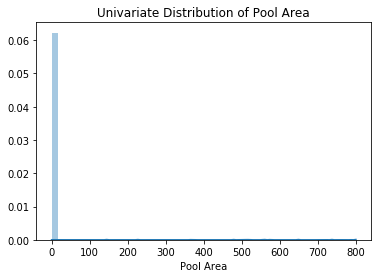

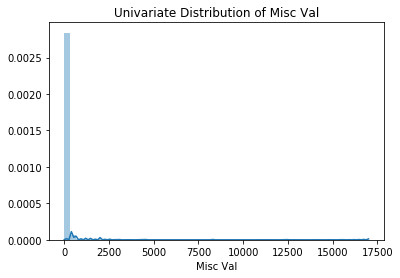

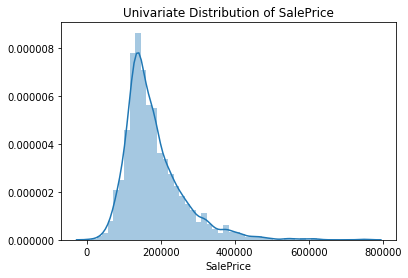

In [13]:
for name in cont_column_names:
    data = df[name]
    fig = sns.distplot(np.array(data.dropna()));
    plt.xlabel(name)
    plt.title(r'Univariate Distribution of ' + str(name))
    plt.show(fig)
    

**Answer**
There are many zero values. While a lot of the graphs have the form of a bell curve, the large amount of zero values generate a relatively large column for an x value of zero for these continuous features. This is a case of sparse data, but no special trament in terms of scaling is really needed because the dataset is not large enough to blow up the RAM. Furthermore, we want to treat zero values as relevant to predicting sales price, so we don't want to give this data any special treatment.

**1.2 Visualize the dependency of the target on each continuous feature (2d scatter plot).**

In [14]:
cont_column_names2 = cont_column_names.copy()

In [15]:
del cont_column_names2[len(cont_column_names2)-1]

In [16]:
#get target data
target_data = np.array(df_imputed['SalePrice'])

2930
2930


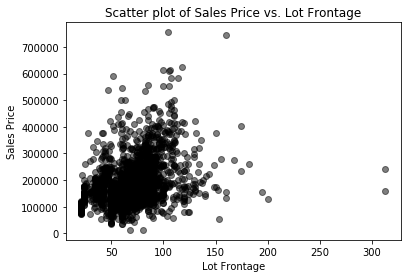

2930
2930


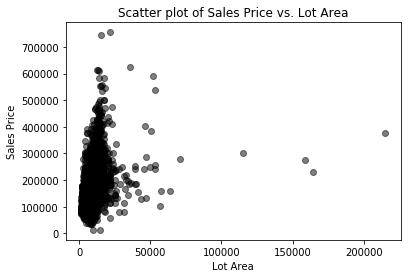

2930
2930


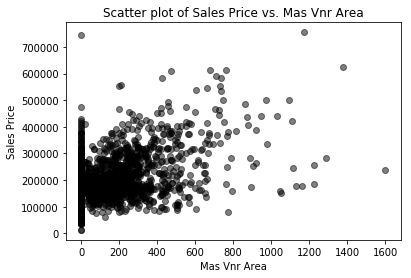

2930
2930


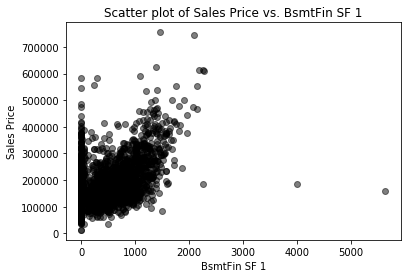

2930
2930


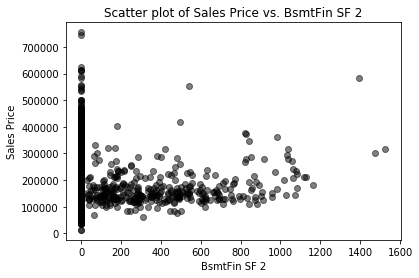

2930
2930


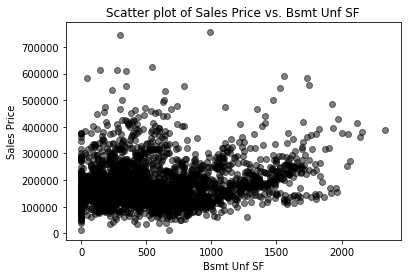

2930
2930


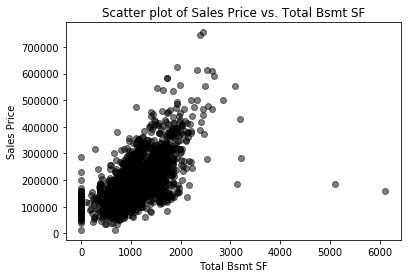

2930
2930


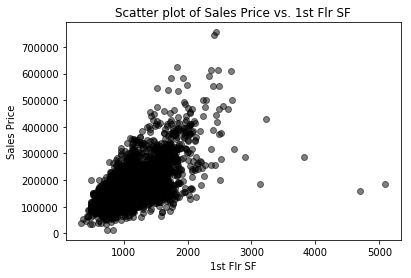

2930
2930


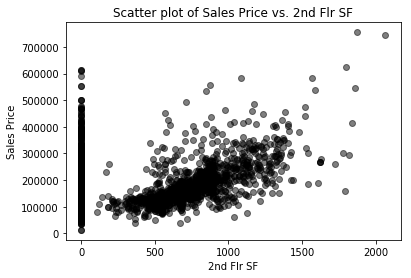

2930
2930


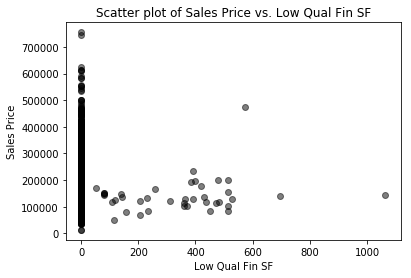

2930
2930


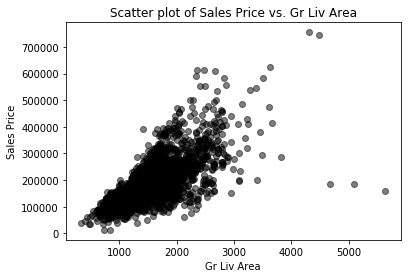

2930
2930


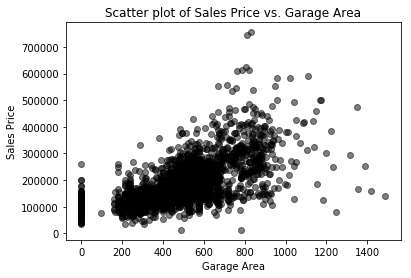

2930
2930


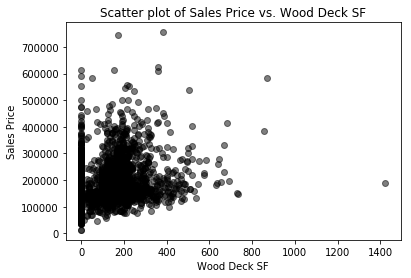

2930
2930


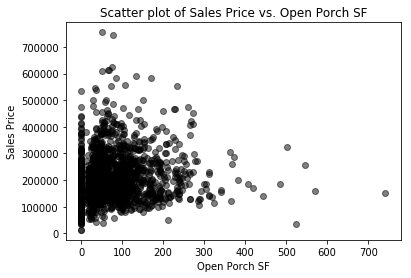

2930
2930


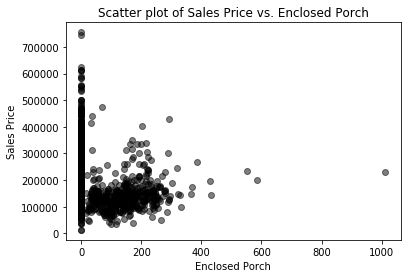

2930
2930


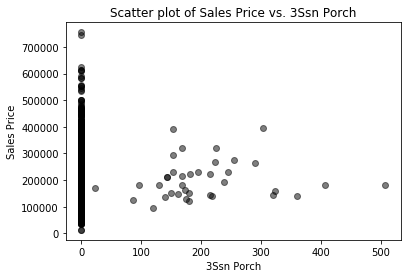

2930
2930


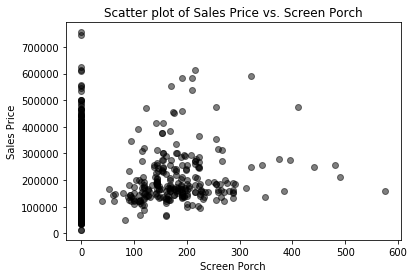

2930
2930


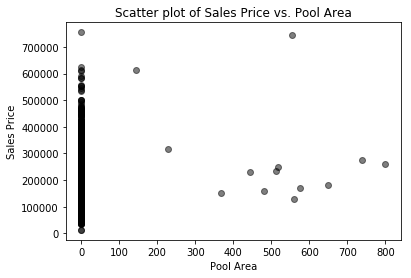

2930
2930


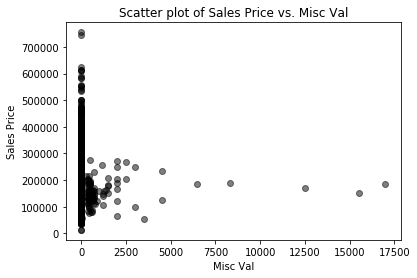

In [17]:
for name in cont_column_names2:
    data = df[name]
    
    x = np.array(data)
    #x = np.array(data.dropna())
    
    print(len(x))
    print(len(target_data))
    
    colors = (0,0,0)
    #area = np.pi*3

    # Plot
    #plt.scatter(x, target_data, s=area, c=colors, alpha=0.5)
    
    plt.scatter(x, target_data, c=colors, alpha=0.5)
    
    plt.title('Scatter plot of Sales Price vs. ' + name)
    plt.xlabel(name)
    plt.ylabel('Sales Price')
    plt.show()

**1.3 Split data in training and test set. Do not use the test-set unless for a final evaluation in 1.6. For each categorical variable, cross-validate a Linear Regression model using just this variable (one-hot-encoded). Visualize the relationship of the categorical variables that provide the best R^2 value with the target.**

In [18]:
#perform train_test split
df_train = df.sample(frac = 0.7)

In [19]:
df_train_14 = df_train.copy()

In [20]:
df_train = df_train.fillna("none")

In [21]:
#column with target var
train_target = np.array(df_train['SalePrice'])

In [22]:
#indices of training data
train_ix = list(df_train.index.get_values())

In [23]:
#datadrame containing all test data
df_test = df.loc[~df.index.isin(train_ix)]

In [24]:
#DOES NOT ACTUALLY RETURN CATEGORICAL DATA
#categorical = df.dtypes == object

In [25]:
cats_names = ['MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type',
 'Sale Condition']

In [26]:
#df_cat_train is a df with only categorical items for the training data
df_cat_train  = df_train[cats_names]

In [27]:
#find r2 cross val scores for all categorical data (plus onehot encode)
results = []
for name in cats_names:
    column = df_cat_train[name].astype(str)
    column = np.array(column).reshape(-1,1)
    ce = OneHotEncoder().fit(column)
    regression_input = ce.transform(column).toarray()
    
    mean_r2 = np.mean(cross_val_score(LinearRegression(), regression_input, train_target, cv=3, scoring = "r2"))
    
    results.append((mean_r2,name))

From here on we have to produce regression for each element individually

In [28]:
#Take top 5 variables
results.sort(reverse=True)

In [29]:
top = results[:5]

In [30]:
#top has the top R^2 results for linear regression
top

[(0.5166546865515097, 'Bsmt Qual'),
 (0.4988548238054191, 'Exter Qual'),
 (0.46561197553662703, 'Kitchen Qual'),
 (0.29771469158318115, 'Fireplace Qu'),
 (0.28594921756896147, 'Garage Finish')]

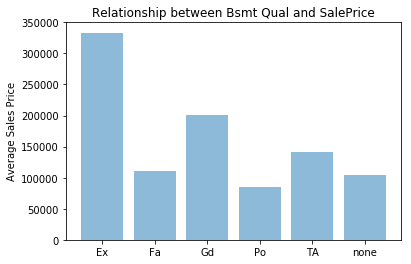

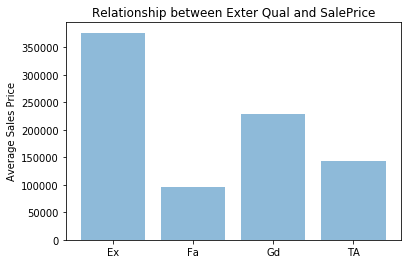

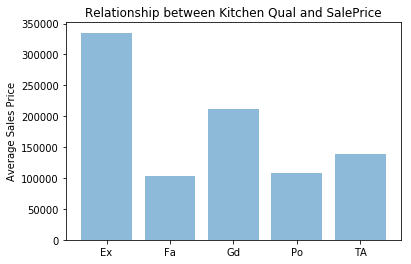

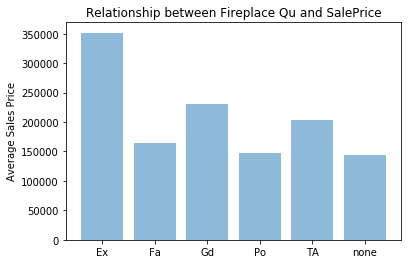

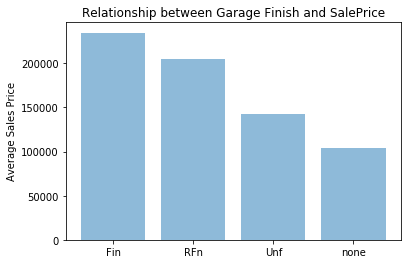

In [31]:
#produce the bar plots for top features
for i in range(len(top)):
    name = top[i][1]
    df_temp = df_train.groupby([top[i][1]])['SalePrice'].mean()
    objects = df_temp.index
    y_pos = np.arange(len(objects))
    values = np.array(df_temp)
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Average Sales Price')
    plt.title('Relationship between ' + name + " and SalePrice")

    plt.show()

**1.4 Use ColumnTransformer and pipeline to encode categorical variables. Evaluate Linear
Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default
parameters. Does scaling the data (within the pipeline) with StandardScaler help?**

In [32]:
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer,  make_column_transformer

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [34]:
#we want our original data frame with filled in nan values AND imputed values
#df_train14 =>copy of original training data for the purposes of this problem

train_col_means = {}

#we need to do fillna on cats columns

#perform imputation on continuous data
for col in cont_column_names:
    #print(col)
    train_col_means[col] = df_train_14[col].mean()
    
    df_train_14[col] = df_train_14[col].fillna(df_train_14[col].mean())
    
    
    
    

In [35]:
#perform fillna on categorical data
for col in cats_names:
    df_train_14[col] = df_train_14[col].fillna("no_cat")
    df_train_14[col] = df_train_14[col].astype(str)
    

In [36]:
#get names of all categorical and continuous columns in one list
all_cols = cats_names + cont_column_names

In [37]:
#do not include sales 
del cont_column_names[len(cont_column_names)-1]

In [38]:
#delete the saleprice
del all_cols[len(all_cols)-1]

In [39]:
#get all the lables in y
y = np.array(df_train_14["SalePrice"]).reshape(-1,1)

In [40]:
#get data frame with only continuous and categorical features
df_train_14 = df_train_14[all_cols] 

In [41]:
#begin design of pipeline
preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'), cats_names)
)

In [42]:
linear_model = make_pipeline(preprocess, LinearRegression())
ridge_model = make_pipeline(preprocess, Ridge())
lasso_model = make_pipeline(preprocess, Lasso())
elasticnet_model = make_pipeline(preprocess, ElasticNet())

In [43]:
linear_scores = cross_val_score(linear_model, df_train_14, y, cv=3)

In [ ]:
ridge_scores = cross_val_score(ridge_model, df_train_14, y, cv=3)
lasso_scores = cross_val_score(lasso_model, df_train_14, y, cv=3)

In [45]:
elasticnet_scores = cross_val_score(elasticnet_model, df_train_14, y, cv=3)

In [46]:
print(linear_scores)
print(ridge_scores)
print(lasso_scores)
print(elasticnet_scores)

[0.7962127  0.79075958 0.81143919]
[0.81558449 0.80867909 0.81800555]
[0.79832731 0.79337306 0.81203902]
[0.65496173 0.64935793 0.63754366]


Now we do the same with scaling

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
"""NOTE: CAN WE SCALE ONLY CONT DATA??????"""

'NOTE: CAN WE SCALE ONLY CONT DATA??????'

In [49]:
#Perform Scaled Preprocessing
scaled_preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'), cats_names),
    (StandardScaler(), cont_column_names)
)

In [50]:
scaled_linear_model = make_pipeline(scaled_preprocess, LinearRegression())
scaled_ridge_model = make_pipeline(scaled_preprocess, Ridge())
scaled_lasso_model = make_pipeline(scaled_preprocess, Lasso())
scaled_elasticnet_model = make_pipeline(scaled_preprocess, ElasticNet())

In [ ]:
scaled_linear_scores = cross_val_score(scaled_linear_model, df_train_14, y, cv=3)

In [ ]:
scaled_ridge_scores = cross_val_score(scaled_ridge_model, df_train_14, y, cv=3)
scaled_lasso_scores = cross_val_score(scaled_lasso_model, df_train_14, y, cv=3)

In [ ]:
scaled_elasticnet_scores = cross_val_score(scaled_elasticnet_model, df_train_14, y, cv=3)

Comparison of scores when scaled and not scaled

In [67]:
print(str(linear_scores) + " " + str(scaled_linear_scores))
print(str(ridge_scores) + " " + str(scaled_ridge_scores))
print(str(lasso_scores) + " " + str(scaled_lasso_scores))
print(str(elasticnet_scores) + " " + str(scaled_elasticnet_scores))

[0.7962127  0.79075958 0.81143919] [0.71941106 0.88090417 0.90096114]
[0.81558449 0.80867909 0.81800555] [0.80597414 0.89261775 0.9018508 ]
[0.79832731 0.79337306 0.81203902] [0.80050435 0.88138847 0.90117857]
[0.65496173 0.64935793 0.63754366] [0.77082468 0.83714956 0.85303145]


The printout in the cell above shows that StandarsScaler() within the pipeline improves corss-validation scores.

**1.5 Tune the parameters of the models using GridSearchCV. Do the results improve?
Visualize the dependence of the validation score on the parameters for Ridge, Lasso and
ElasticNet.**

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
df_train_15 = df_train_14.copy()

In [70]:
ridge_param_grid = {'ridge__alpha': np.logspace(-3, 3, 13)}

In [71]:
ridge_grid = GridSearchCV(scaled_ridge_model, ridge_param_grid, cv=10, scoring = "r2")

In [ ]:
ridge_grid.fit(df_train_15, y)

In [73]:
print(ridge_grid.best_params_)

{'ridge__alpha': 10.0}


In [74]:
a = []

for i in range(13):
    a.append(i)

In [75]:
target_data = ridge_grid.cv_results_["mean_test_score"]
x = np.logspace(-3, 3, 13)

In [80]:
x = list(x)

In [81]:
for i in range(len(x)):
    x[i] = str(x[i])[:5]

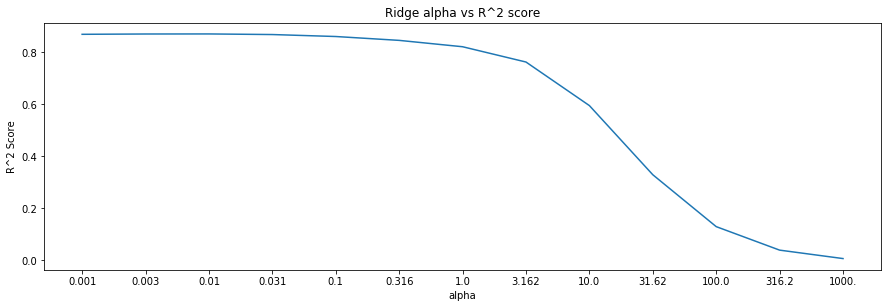

In [171]:
fig= plt.figure(1, figsize=(15,10))
ax1  = fig.add_subplot(211)
#ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_ticks(a) #set the ticks to be a
ax1.xaxis.set_ticklabels(x)

ax1.set_xlabel("alpha")
ax1.set_ylabel("R^2 Score")
ax1.set_title("Ridge alpha vs R^2 score")

ax1.plot(a, target_data) #we plot y as a function of a, which parametrizes x

In [ ]:
lasso_param_grid = {'lasso__alpha': np.logspace(-3, 3, 13)}
lasso_grid = GridSearchCV(scaled_lasso_model, lasso_param_grid, cv=10)
lasso_grid.fit(df_train_15, y)

In [84]:
print(lasso_grid.best_params_)

{'lasso__alpha': 31.622776601683793}


In [85]:
target_data = lasso_grid.cv_results_["mean_test_score"]

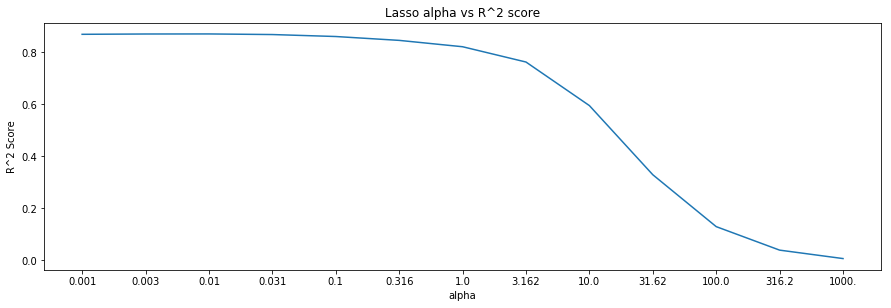

In [172]:
fig= plt.figure(1, figsize=(15,10))
ax1  = fig.add_subplot(211)
#ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_ticks(a) #set the ticks to be a
ax1.xaxis.set_ticklabels(x)

ax1.set_xlabel("alpha")
ax1.set_ylabel("R^2 Score")
ax1.set_title("Lasso alpha vs R^2 score")

ax1.plot(a, target_data) #we plot y as a function of a, which parametrizes x

In [ ]:
elasticnet_param_grid = {'elasticnet__alpha': np.logspace(-3, 3, 13)}
elasticnet_grid = GridSearchCV(scaled_elasticnet_model, elasticnet_param_grid, cv=10)
elasticnet_grid.fit(df_train_15, y)

In [88]:
print(elasticnet_grid.best_params_)

{'elasticnet__alpha': 0.01}


In [89]:
target_data = elasticnet_grid.cv_results_["mean_test_score"]

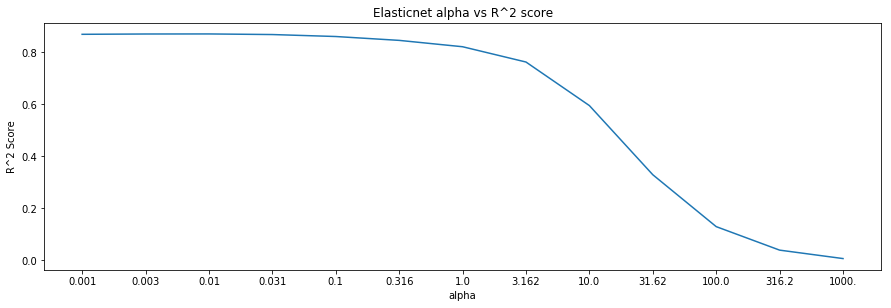

In [173]:
fig= plt.figure(1, figsize=(15,10))
ax1  = fig.add_subplot(211)
#ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_ticks(a) #set the ticks to be a
ax1.xaxis.set_ticklabels(x)

ax1.set_xlabel("alpha")
ax1.set_ylabel("R^2 Score")
ax1.set_title("Elasticnet alpha vs R^2 score")

ax1.plot(a, target_data) #we plot y as a function of a, which parametrizes x

**1.6 Visualize the coefficients of the resulting models. Do they agree on which features are
important?**

In [139]:
#recover all the original feature names
onehotcat_feature_names = list(scaled_preprocess.named_transformers_['onehotencoder'].get_feature_names())

In [177]:
all_col_names_transformed = np.array(onehotcat_feature_names + cont_column_names)

In [91]:
X =  scaled_preprocess.fit_transform(df_train_14)

/home/andres/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/andres/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Fit the differenet regression models with th eparamters cound above

In [95]:
ridge = Ridge(alpha=10.0).fit(X, y)

In [147]:
lasso = Lasso(alpha=31.622776601683793).fit(X,y)

/home/andres/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [148]:
elastic = ElasticNet(alpha = 0.01).fit(X,y)

/home/andres/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


**Visualization**

In [174]:
#save top coefficients for each model 
r_c = abs(ridge.coef_).flatten().argsort()[-10:][::-1]
la_c = abs(lasso.coef_).flatten().argsort()[-10:][::-1]
en_c = abs(elastic.coef_).flatten().argsort()[-10:][::-1]

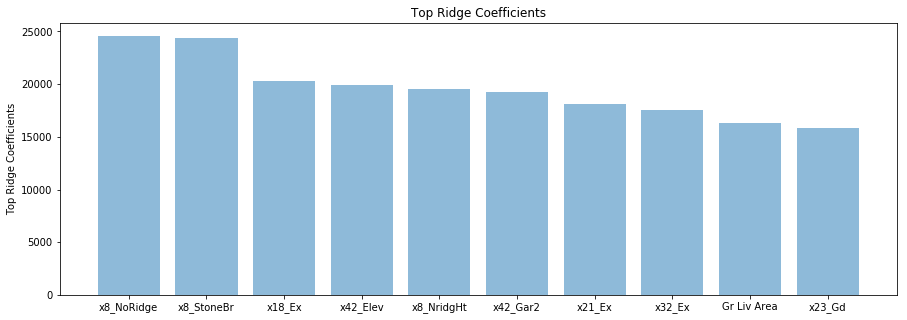

In [197]:
objects = all_col_names_transformed[r_c]
y_pos = np.arange(len(objects))
values = np.array(abs(ridge.coef_.flatten()[r_c]))
plt.figure(figsize=(15,5))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel("Top Ridge Coefficients")
plt.title(name)
plt.show()

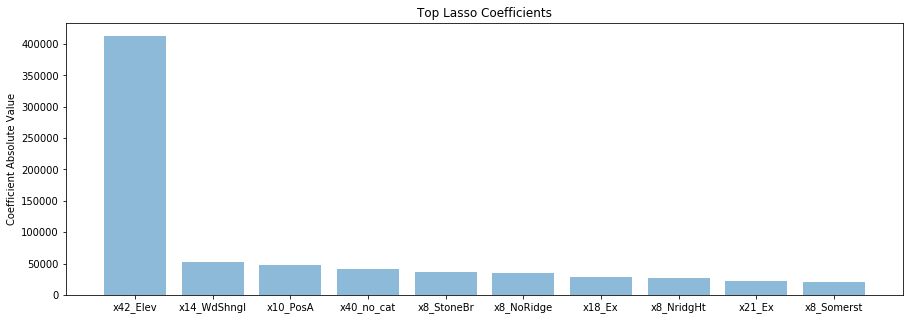

In [193]:
objects = all_col_names_transformed[la_c]
values = np.array(abs(lasso.coef_.flatten()[la_c]))
plt.figure(figsize=(15,5))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Coefficient Absolute Value')
plt.title("Top Lasso Coefficients")
plt.show()

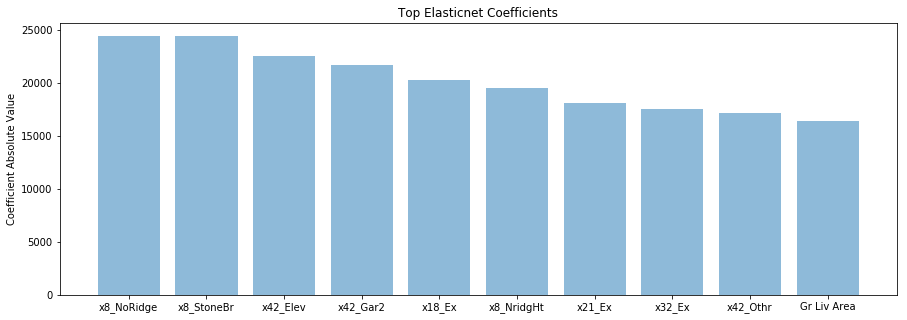

In [195]:
objects = all_col_names_transformed[en_c]
values = np.array(abs(elastic.coef_.flatten()[en_c]))
plt.figure(figsize=(15,5))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Coefficient Absolute Value')
plt.title("Top Elasticnet Coefficients")
plt.show()

In [198]:
a=all_col_names_transformed[r_c]
b=all_col_names_transformed[la_c]
c=all_col_names_transformed[en_c]

Below we print the top coefficients sfor ridge, lasso, and elastic net

In [199]:
print(a)
print(b)
print(c)

['x8_NoRidge' 'x8_StoneBr' 'x18_Ex' 'x42_Elev' 'x8_NridgHt' 'x42_Gar2'
 'x21_Ex' 'x32_Ex' 'Gr Liv Area' 'x23_Gd']
['x42_Elev' 'x14_WdShngl' 'x10_PosA' 'x40_no_cat' 'x8_StoneBr'
 'x8_NoRidge' 'x18_Ex' 'x8_NridgHt' 'x21_Ex' 'x8_Somerst']
['x8_NoRidge' 'x8_StoneBr' 'x42_Elev' 'x42_Gar2' 'x18_Ex' 'x8_NridgHt'
 'x21_Ex' 'x32_Ex' 'x42_Othr' 'Gr Liv Area']


The following coefficients are the ones that are most important, that is, that have the highest absolute value in each of the three models. The intersection between the three yields 6 elements in common in the 10 most important features for each. 

In [202]:
np.intersect1d(np.intersect1d(a,b),c)

array(['x18_Ex', 'x21_Ex', 'x42_Elev', 'x8_NoRidge', 'x8_NridgHt',
       'x8_StoneBr'], dtype='<U15')